<a href="https://colab.research.google.com/github/SwaksharDeb/Activity-recognition/blob/master/HAR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import array
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from numpy import savetxt
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import scipy.stats as stats
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.utils import class_weight
import matplotlib as mpl
from tensorflow.keras.optimizers import Adam

# Importing the dataset

In [ ]:
dataset_user04 = pd.read_csv("final_field_user04_dataset.csv")
dataset_user07 = pd.read_csv("final_field_user07_dataset.csv")
dataset_user08 = pd.read_csv("final_field_user08_dataset.csv")
dataset_user18 = pd.read_csv("final_field_user18_dataset.csv")
dataset_user38 = pd.read_csv("final_field_user38_dataset.csv")
dataset_user51 = pd.read_csv("final_field_user51_dataset.csv")
dataset_lab = pd.read_csv("sample_data.csv")

# Data processing

In [ ]:
dataset = pd.concat([dataset_lab, dataset_user04, dataset_user07, dataset_user08, dataset_user18, dataset_user38, dataset_user51], ignore_index = True)

In [ ]:
dataset.head()

,x,y,z,act_id
0,-1.8,9.19,0.21,1
1,-1.8,9.38,0.19,1
2,-7.7,5.98,0.04,1
3,-9.5,0.92,0.11,1
4,-9.5,0.92,0.09,1


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2045852 entries, 0 to 2045851
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   x       float64
 1   y       float64
 2   z       float64
 3   act_id  int64  
dtypes: float64(3), int64(1)
memory usage: 62.4 MB


In [ ]:
dataset_lab['act_id'].value_counts()

In [ ]:
dataset['act_id'].value_counts()

5     1094887
4      430978
7      129146
3      117302
12      76803
1       42810
6       37158
10      26558
11      24586
9       22638
8       21936
2       21050
Name: act_id, dtype: int64

In [ ]:
dataset = pd.concat([dataset_user04, dataset_user07, dataset_user08, dataset_user18, dataset_user51,dataset_user38], ignore_index = True)
#dataset_test = pd.concat([dataset_user38, dataset_user51], ignore_index = True)

In [ ]:
X = dataset.iloc[:, [0, 1, 2]].values
#X_test = dataset_test.iloc[:, [0, 1, 2]].values
Y = dataset.iloc[:, 3].values
#Y_test = dataset_test.iloc[:, 3].values
Y = Y - 1
#Y_test = Y_test -1

In [ ]:
Counter(Y)

Counter({0: 42810,
         1: 21050,
         2: 117302,
         3: 430978,
         4: 1094887,
         5: 37158,
         6: 129146,
         7: 21936,
         8: 22638,
         9: 26558,
         10: 24586,
         11: 76803})

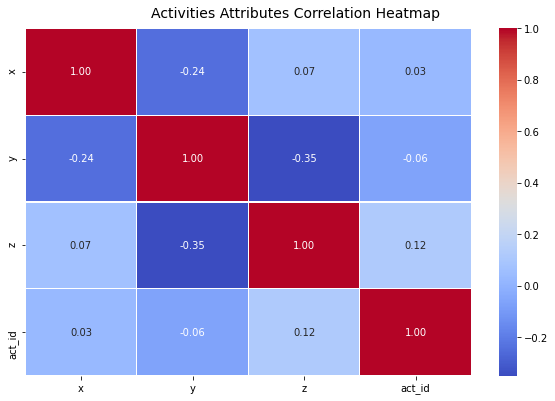

In [ ]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = dataset.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Activities Attributes Correlation Heatmap', fontsize=14)

Text(0, 0.5, 'x')

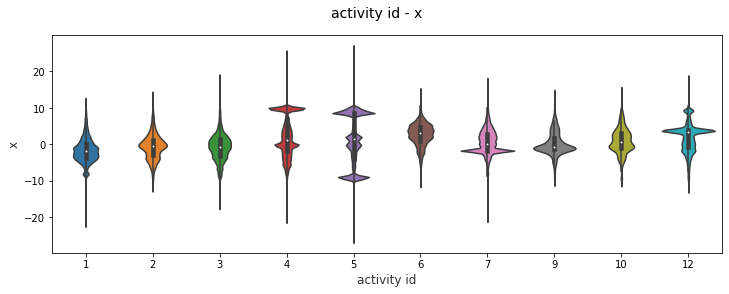

In [ ]:
# Violin Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('activity id - x', fontsize=14)

sns.violinplot(x="act_id", y="x", data=dataset,  ax=ax)
ax.set_xlabel("activity id",size = 12,alpha=0.8)
ax.set_ylabel("x",size = 12,alpha=0.8)

# Unbalance dataset

In [ ]:
#sc = StandardScaler()
sc = MinMaxScaler(feature_range = (0, 1)
X_scaled = sc.fit_transform(X)
#X_test_scaled = sc.fit_transform(X_test)
Fs = 20
frame_size = Fs*4 # 80
hop_size = 5 #Fs*2 # 40

def get_frames(data, frame_size, hop_size, data_label):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, data.shape[0] - frame_size, hop_size):
        x = data[i: i + frame_size, 0]
        y = data[i: i + frame_size, 1]
        z = data[i: i + frame_size, 2]

        # Retrieve the most often used label in this segment
        label = stats.mode(data_label[i: i + frame_size])[0][0]
        #label = data_label[i: i + frame_size]
        #if len(np.unique(label)) >= 2:
          #continue
        #else:
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

X_train, y_train = get_frames(X_scaled, frame_size, hop_size, Y)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0, stratify = y_train)

In [ ]:
np.count_nonzero(y_train == 1), len(np.unique(y_train))

(54, 10)

## Weighted sampling for Dealing with class imbalance

In [ ]:
class_weights = {}
for classes in np.unique(y_train):
    class_weights[classes] = len(X_train)/(np.count_nonzero(y_train == classes)
                                     *len(np.unique(y_train)))

In [ ]:
class_weights

{0: 3.976818778247558,
 1: 8.091664194601009,
 2: 1.4533780903665814,
 3: 0.39533029942896897,
 4: 0.15572797131732494,
 5: 4.587453750420451,
 6: 1.3213680182144067,
 7: 7.7712250712250714,
 8: 7.54759269507471,
 9: 6.433254716981132,
 10: 6.931893265565439,
 11: 2.2208923628073602}

In [ ]:
X_train = X_train.reshape(-1, frame_size, 3, 1)
X_val = X_val.reshape(-1, frame_size, 3, 1)

In [ ]:
X_train.shape, y_train.shape

((327324, 80, 3, 1), (327324,))

## CNN model using weighted sampling

In [ ]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', padding = 'same', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu', padding= 'same'))
model.add(Dropout(0.2))

#model.add(Conv2D(32, (2, 2), activation='relu', padding= 'same'))

#model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
#model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(12, activation='softmax'))

model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs = 100, validation_data= (X_val, y_val), class_weight=class_weights, verbose=1)

Epoch 1/100
10229/10229 [==============================] - 259s 25ms/step - loss: 1.9611 - accuracy: 0.4123 - val_loss: 1.4711 - val_accuracy: 0.4443
Epoch 2/100
10229/10229 [==============================] - 253s 25ms/step - loss: 1.7269 - accuracy: 0.4495 - val_loss: 1.4057 - val_accuracy: 0.4460
Epoch 3/100
10229/10229 [==============================] - 256s 25ms/step - loss: 1.6484 - accuracy: 0.4602 - val_loss: 1.3172 - val_accuracy: 0.4908
Epoch 4/100
10229/10229 [==============================] - 256s 25ms/step - loss: 1.5952 - accuracy: 0.4664 - val_loss: 1.3664 - val_accuracy: 0.4730
Epoch 5/100
10229/10229 [==============================] - 252s 25ms/step - loss: 1.5619 - accuracy: 0.4744 - val_loss: 1.3347 - val_accuracy: 0.4768
Epoch 6/100
10229/10229 [==============================] - 248s 24ms/step - loss: 1.5294 - accuracy: 0.4775 - val_loss: 1.2883 - val_accuracy: 0.4891
Epoch 7/100
10229/10229 [==============================] - 247s 24ms/step - loss: 1.5090 - accuracy:

KeyboardInterrupt: ignored

## Balancing the dataset

In [ ]:
act_id_1 = dataset[dataset['act_id']==1].head(21050).copy()
act_id_2 = dataset[dataset['act_id']==2].head(21050).copy()
act_id_3 = dataset[dataset['act_id']==3].head(21050).copy()
act_id_4 = dataset[dataset['act_id']==4].head(21050).copy()
act_id_5 = dataset[dataset['act_id']==5].head(21050).copy()
act_id_6 = dataset[dataset['act_id']==6].head(21050).copy()
act_id_7 = dataset[dataset['act_id']==7].head(21050).copy()
act_id_8 = dataset[dataset['act_id']==8].head(21050).copy()
act_id_9 = dataset[dataset['act_id']==9].head(21050).copy()
act_id_10 = dataset[dataset['act_id']==10].head(21050).copy()
act_id_11 = dataset[dataset['act_id']==11].head(21050).copy()
act_id_12 = dataset[dataset['act_id']==12].head(21050).copy()

In [ ]:
balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([act_id_1, act_id_2, act_id_3, act_id_4, act_id_5, act_id_6, act_id_7, act_id_8, act_id_9, act_id_10, act_id_11, act_id_12])
balanced_data.reset_index(drop=True, inplace = True)
balanced_data.shape

(252600, 4)

In [ ]:
X = balanced_data.iloc[:, [0, 1, 2]].values
Y = balanced_data.iloc[:, 3].values
Y = Y - 1

In [ ]:
Counter(Y)

Counter({0: 21050,
         1: 21050,
         2: 21050,
         3: 21050,
         4: 21050,
         5: 21050,
         6: 21050,
         7: 21050,
         8: 21050,
         9: 21050,
         10: 21050,
         11: 21050})

In [ ]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

Fs = 20
frame_size = Fs*4 # 80
hop_size = 1 #Fs*2 # 40

def get_frames(data, frame_size, hop_size, data_label):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, data.shape[0] - frame_size, hop_size):
        x = data[i: i + frame_size, 0]
        y = data[i: i + frame_size, 1]
        z = data[i: i + frame_size, 2]

        # Retrieve the most often used label in this segment
        label = stats.mode(data_label[i: i + frame_size])[0][0]
        #label = data_label[i: i + frame_size]
        #if len(np.unique(label)) >= 2:
          #continue
        #else:
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

X_train, y_train = get_frames(X_scaled, frame_size, hop_size, Y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0, stratify = y_train)

In [ ]:
X_train = X_train.reshape(-1, frame_size, 3, 1)
X_val = X_val.reshape(-1, frame_size, 3, 1)

In [ ]:
X_train.shape, X_val.shape

((202016, 80, 3, 1), (50504, 80, 3, 1))

In [ ]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', padding = 'same', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu', padding= 'same'))
model.add(Dropout(0.2))

#model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
#model.add(Dropout(0.2))

model.add(Flatten())

#model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(12, activation='softmax'))

model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs = 50, validation_data= (X_val, y_val), verbose=1)

Epoch 1/50
6313/6313 [==============================] - 108s 17ms/step - loss: 2.1562 - accuracy: 0.2186 - val_loss: 1.8803 - val_accuracy: 0.3344
Epoch 2/50
6313/6313 [==============================] - 108s 17ms/step - loss: 2.0174 - accuracy: 0.2577 - val_loss: 1.7886 - val_accuracy: 0.3665
Epoch 3/50
6313/6313 [==============================] - 107s 17ms/step - loss: 1.9643 - accuracy: 0.2741 - val_loss: 1.7363 - val_accuracy: 0.3804
Epoch 4/50
6313/6313 [==============================] - 106s 17ms/step - loss: 1.9229 - accuracy: 0.2878 - val_loss: 1.6779 - val_accuracy: 0.4052
Epoch 5/50
6313/6313 [==============================] - 107s 17ms/step - loss: 1.8884 - accuracy: 0.3020 - val_loss: 1.6243 - val_accuracy: 0.4178
Epoch 6/50
6313/6313 [==============================] - 107s 17ms/step - loss: 1.8590 - accuracy: 0.3142 - val_loss: 1.6060 - val_accuracy: 0.4275
Epoch 7/50
6313/6313 [==============================] - 110s 17ms/step - loss: 1.8371 - accuracy: 0.3220 - val_loss: 1

In [ ]:
balanced_data.head()

,x,y,z,act_id
0,-0.153,6.397,5.773,1
1,-0.153,6.397,5.773,1
2,-2.068,9.079,5.823,1
3,-4.980,7.891,0.036,1
4,-4.980,7.891,0.036,1


In [ ]:
act_id_12.head()

,x,y,z,act_id
98016,-1.494,7.508,7.098,12
98017,-1.494,7.508,7.098,12
98018,-1.494,7.508,7.098,12
98019,-1.494,7.508,7.098,12
98020,-0.996,10.496,2.565,12


In [ ]:
balanced_data['act_id'].value_counts()

12    2028
10    2028
7     2028
6     2028
5     2028
4     2028
3     2028
2     2028
1     2028
9     1206
Name: act_id, dtype: int64

## Seperating features and label

In [ ]:

X = balanced_data.iloc[:, [0, 1, 2]].values
X_test = dataset_test.iloc[:, [0, 1, 2]].values
Y = balanced_data.iloc[:, 3].values
Y_test = dataset_test.iloc[:, 3].values
Y = Y - 1
Y_test = Y_test -1

In [ ]:
X.shape, Y.shape, X_test.shape

((19458, 3), (19458,), (26331, 3))

In [ ]:
smote = SMOTE()
X, Y = smote.fit_sample(X ,Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
Counter(Y)

Counter({0: 1074348,
         1: 1074348,
         2: 1074348,
         3: 1074348,
         4: 1074348,
         5: 1074348,
         6: 1074348,
         8: 1074348,
         9: 1074348,
         11: 1074348})

## Feature scaling

In [ ]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
#X_test_scaled = sc.fit_transform(X_test)

In [ ]:
X_scaled.shape[0]

19458

In [ ]:
X_scaled

array([[-0.27656389, -0.3676683 ,  1.5233801 ],
       [-0.27656389, -0.3676683 ,  1.5233801 ],
       [-0.72634477,  0.56098859,  1.53928704],
       ...,
       [ 1.94556504, -2.66195637, -0.42076578],
       [ 1.93663989, -2.66195637, -0.42076578],
       [ 1.93663989, -2.63564096, -0.4201295 ]])

## Test train split

## Making the frame

In [ ]:
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

def get_frames(data, frame_size, hop_size, data_label):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, data.shape[0] - frame_size, hop_size):
        x = data[i: i + frame_size, 0]
        y = data[i: i + frame_size, 1]
        z = data[i: i + frame_size, 2]

        # Retrieve the most often used label in this segment
        label = stats.mode(data_label[i: i + frame_size])[0][0]
        #label = data_label[i: i + frame_size]
        #if len(np.unique(label)) >= 2:
          #continue
        #else:
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

X_train, y_train = get_frames(X_scaled, frame_size, hop_size, Y)
#X_test, y_test = get_frames(X_test_scaled, frame_size, hop_size, Y_test)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape 

((19378, 80, 3), (19378,), (26251, 80, 3), (26251,))

In [ ]:
X_train.shape, y_train.shape

((19378, 80, 3), (19378,))

## Train-Test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0, stratify = y_train)

In [ ]:
Counter(y_train), Counter(y_test)

(Counter({0: 454,
          1: 54,
          2: 1947,
          3: 8141,
          4: 21482,
          5: 312,
          6: 2174,
          8: 39,
          9: 42,
          11: 949}),
 Counter({0: 57,
          1: 7,
          2: 243,
          3: 1018,
          4: 2686,
          5: 39,
          6: 272,
          8: 5,
          9: 5,
          11: 118}))

In [ ]:
class_0 = Counter(y_train)[0]/(Counter(y_train)[0]+Counter(y_train)[1]+Counter(y_train)[2]+Counter(y_train)[3]+Counter(y_train)[4]+Counter(y_train)[5]+Counter(y_train)[6]+Counter(y_train)[7]+Counter(y_train)[8]+Counter(y_train)[9]+Counter(y_train)[10]+Counter(y_train)[11]) *100
class_1 = Counter(y_train)[1]/(Counter(y_train)[0]+Counter(y_train)[1]+Counter(y_train)[2]+Counter(y_train)[3]+Counter(y_train)[4]+Counter(y_train)[5]+Counter(y_train)[6]+Counter(y_train)[7]+Counter(y_train)[8]+Counter(y_train)[9]+Counter(y_train)[10]+Counter(y_train)[11])*100 
class_2 = Counter(y_train)[2]/(Counter(y_train)[0]+Counter(y_train)[1]+Counter(y_train)[2]+Counter(y_train)[3]+Counter(y_train)[4]+Counter(y_train)[5]+Counter(y_train)[6]+Counter(y_train)[7]+Counter(y_train)[8]+Counter(y_train)[9]+Counter(y_train)[10]+Counter(y_train)[11])*100
class_3 = Counter(y_train)[3]/(Counter(y_train)[0]+Counter(y_train)[1]+Counter(y_train)[2]+Counter(y_train)[3]+Counter(y_train)[4]+Counter(y_train)[5]+Counter(y_train)[6]+Counter(y_train)[7]+Counter(y_train)[8]+Counter(y_train)[9]+Counter(y_train)[10]+Counter(y_train)[11])*100 
class_4 = Counter(y_train)[4]/(Counter(y_train)[0]+Counter(y_train)[1]+Counter(y_train)[2]+Counter(y_train)[3]+Counter(y_train)[4]+Counter(y_train)[5]+Counter(y_train)[6]+Counter(y_train)[7]+Counter(y_train)[8]+Counter(y_train)[9]+Counter(y_train)[10]+Counter(y_train)[11])*100 
class_5 = Counter(y_train)[5]/(Counter(y_train)[0]+Counter(y_train)[1]+Counter(y_train)[2]+Counter(y_train)[3]+Counter(y_train)[4]+Counter(y_train)[5]+Counter(y_train)[6]+Counter(y_train)[7]+Counter(y_train)[8]+Counter(y_train)[9]+Counter(y_train)[10]+Counter(y_train)[11])*100 
class_6 = Counter(y_train)[6]/(Counter(y_train)[0]+Counter(y_train)[1]+Counter(y_train)[2]+Counter(y_train)[3]+Counter(y_train)[4]+Counter(y_train)[5]+Counter(y_train)[6]+Counter(y_train)[7]+Counter(y_train)[8]+Counter(y_train)[9]+Counter(y_train)[10]+Counter(y_train)[11])*100 
class_7 = Counter(y_train)[7]/(Counter(y_train)[0]+Counter(y_train)[1]+Counter(y_train)[2]+Counter(y_train)[3]+Counter(y_train)[4]+Counter(y_train)[5]+Counter(y_train)[6]+Counter(y_train)[7]+Counter(y_train)[8]+Counter(y_train)[9]+Counter(y_train)[10]+Counter(y_train)[11])*100 
class_8 = Counter(y_train)[8]/(Counter(y_train)[0]+Counter(y_train)[1]+Counter(y_train)[2]+Counter(y_train)[3]+Counter(y_train)[4]+Counter(y_train)[5]+Counter(y_train)[6]+Counter(y_train)[7]+Counter(y_train)[8]+Counter(y_train)[9]+Counter(y_train)[10]+Counter(y_train)[11])*100 
class_9 = Counter(y_train)[9]/(Counter(y_train)[0]+Counter(y_train)[1]+Counter(y_train)[2]+Counter(y_train)[3]+Counter(y_train)[4]+Counter(y_train)[5]+Counter(y_train)[6]+Counter(y_train)[7]+Counter(y_train)[8]+Counter(y_train)[9]+Counter(y_train)[10]+Counter(y_train)[11])*100 
class_10 = Counter(y_train)[10]/(Counter(y_train)[0]+Counter(y_train)[1]+Counter(y_train)[2]+Counter(y_train)[3]+Counter(y_train)[4]+Counter(y_train)[5]+Counter(y_train)[6]+Counter(y_train)[7]+Counter(y_train)[8]+Counter(y_train)[9]+Counter(y_train)[10]+Counter(y_train)[11])*100 
class_11 = Counter(y_train)[11]/(Counter(y_train)[0]+Counter(y_train)[1]+Counter(y_train)[2]+Counter(y_train)[3]+Counter(y_train)[4]+Counter(y_train)[5]+Counter(y_train)[6]+Counter(y_train)[7]+Counter(y_train)[8]+Counter(y_train)[9]+Counter(y_train)[10]+Counter(y_train)[11])*100 


In [ ]:
class_0, class_1, class_2, class_3, class_4, class_5, class_6, class_7, class_8, class_9, class_10, class_11 

(1.2754958700904646,
 0.15171096252177332,
 5.470023037590606,
 22.87183233129179,
 60.35286846097657,
 0.8765522279035792,
 6.107770972635838,
 0.0,
 0.1095690284879474,
 0.1179974152947126,
 0.0,
 2.66617969320672)

In [ ]:
class_0 = Counter(y_val)[0]/(Counter(y_val)[0]+Counter(y_val)[1]+Counter(y_val)[2]+Counter(y_val)[3]+Counter(y_val)[4]+Counter(y_val)[5]+Counter(y_val)[6]+Counter(y_val)[7]+Counter(y_val)[8]+Counter(y_val)[9]+Counter(y_val)[10]+Counter(y_val)[11]) *100
class_1 = Counter(y_val)[1]/(Counter(y_val)[0]+Counter(y_val)[1]+Counter(y_val)[2]+Counter(y_val)[3]+Counter(y_val)[4]+Counter(y_val)[5]+Counter(y_val)[6]+Counter(y_val)[7]+Counter(y_val)[8]+Counter(y_val)[9]+Counter(y_val)[10]+Counter(y_val)[11]) *100
class_2 = Counter(y_val)[2]/(Counter(y_val)[0]+Counter(y_val)[1]+Counter(y_val)[2]+Counter(y_val)[3]+Counter(y_val)[4]+Counter(y_val)[5]+Counter(y_val)[6]+Counter(y_val)[7]+Counter(y_val)[8]+Counter(y_val)[9]+Counter(y_val)[10]+Counter(y_val)[11]) *100
class_3 = Counter(y_val)[3]/(Counter(y_val)[0]+Counter(y_val)[1]+Counter(y_val)[2]+Counter(y_val)[3]+Counter(y_val)[4]+Counter(y_val)[5]+Counter(y_val)[6]+Counter(y_val)[7]+Counter(y_val)[8]+Counter(y_val)[9]+Counter(y_val)[10]+Counter(y_val)[11]) *100
class_4 = Counter(y_val)[4]/(Counter(y_val)[0]+Counter(y_val)[1]+Counter(y_val)[2]+Counter(y_val)[3]+Counter(y_val)[4]+Counter(y_val)[5]+Counter(y_val)[6]+Counter(y_val)[7]+Counter(y_val)[8]+Counter(y_val)[9]+Counter(y_val)[10]+Counter(y_val)[11]) *100
class_5 = Counter(y_val)[5]/(Counter(y_val)[0]+Counter(y_val)[1]+Counter(y_val)[2]+Counter(y_val)[3]+Counter(y_val)[4]+Counter(y_val)[5]+Counter(y_val)[6]+Counter(y_val)[7]+Counter(y_val)[8]+Counter(y_val)[9]+Counter(y_val)[10]+Counter(y_val)[11]) *100
class_6 = Counter(y_val)[6]/(Counter(y_val)[0]+Counter(y_val)[1]+Counter(y_val)[2]+Counter(y_val)[3]+Counter(y_val)[4]+Counter(y_val)[5]+Counter(y_val)[6]+Counter(y_val)[7]+Counter(y_val)[8]+Counter(y_val)[9]+Counter(y_val)[10]+Counter(y_val)[11]) *100
class_7 = Counter(y_val)[7]/(Counter(y_val)[0]+Counter(y_val)[1]+Counter(y_val)[2]+Counter(y_val)[3]+Counter(y_val)[4]+Counter(y_val)[5]+Counter(y_val)[6]+Counter(y_val)[7]+Counter(y_val)[8]+Counter(y_val)[9]+Counter(y_val)[10]+Counter(y_val)[11]) *100
class_8 = Counter(y_val)[8]/(Counter(y_val)[0]+Counter(y_val)[1]+Counter(y_val)[2]+Counter(y_val)[3]+Counter(y_val)[4]+Counter(y_val)[5]+Counter(y_val)[6]+Counter(y_val)[7]+Counter(y_val)[8]+Counter(y_val)[9]+Counter(y_val)[10]+Counter(y_val)[11]) *100
class_9 = Counter(y_val)[9]/(Counter(y_val)[0]+Counter(y_val)[1]+Counter(y_val)[2]+Counter(y_val)[3]+Counter(y_val)[4]+Counter(y_val)[5]+Counter(y_val)[6]+Counter(y_val)[7]+Counter(y_val)[8]+Counter(y_val)[9]+Counter(y_val)[10]+Counter(y_val)[11]) *100
class_10 = Counter(y_val)[10]/(Counter(y_val)[0]+Counter(y_val)[1]+Counter(y_val)[2]+Counter(y_val)[3]+Counter(y_val)[4]+Counter(y_val)[5]+Counter(y_val)[6]+Counter(y_val)[7]+Counter(y_val)[8]+Counter(y_val)[9]+Counter(y_val)[10]+Counter(y_val)[11]) *100
class_11 = Counter(y_val)[11]/(Counter(y_val)[0]+Counter(y_val)[1]+Counter(y_val)[2]+Counter(y_val)[3]+Counter(y_val)[4]+Counter(y_val)[5]+Counter(y_val)[6]+Counter(y_val)[7]+Counter(y_val)[8]+Counter(y_val)[9]+Counter(y_val)[10]+Counter(y_val)[11]) *100


In [ ]:
class_0, class_1, class_2, class_3, class_4, class_5, class_6, class_7, class_8, class_9, class_10, class_11 

(1.269805596134397,
 0.15732104730868637,
 5.472525002809305,
 22.867737948084056,
 60.355096078211034,
 0.8765029778626812,
 6.101809192044049,
 0.0,
 0.11237217664906168,
 0.12360939431396785,
 0.0,
 2.663220586582762)

In [ ]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

In [ ]:
smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train ,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
X_train = np.reshape(X_train,(-1, frame_size, 3))

In [ ]:
X_train.shape

(214820, 80, 3)

In [ ]:
Counter(y_train), Counter(y_val)

(Counter({0: 21482,
          1: 21482,
          2: 21482,
          3: 21482,
          4: 21482,
          5: 21482,
          6: 21482,
          8: 21482,
          9: 21482,
          11: 21482}),
 Counter({0: 113,
          1: 14,
          2: 487,
          3: 2035,
          4: 5371,
          5: 78,
          6: 543,
          8: 10,
          9: 11,
          11: 237}))

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=0)
for train_index, test_index in sss.split(X_train, y_train):
     print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X_train[train_index], X_train[test_index]
     y_train, y_test = y_train[train_index], y_train[test_index]

TRAIN: [36833 10049 37549 ...  2191 19246 26334] TEST: [12501 23154 35039 ... 31264 20884 24833]
TRAIN: [18026 10573 36436 ... 12593 20678 12538] TEST: [25655 22261 33012 ... 32285  8505 27230]


IndexError: ignored

In [ ]:
X_train.shape

(22246, 80, 3)

In [ ]:
X_train[0].shape, X_val[0].shape

((100, 3), (100, 3))

In [ ]:
X_train = X_train.reshape(-1, frame_size, 3, 1)
X_val = X_val.reshape(-1, frame_size, 3, 1)
#X_test = X_test.reshape(-1, frame_size, 3, 1)

In [ ]:
X_train[0].shape, X_val[0].shape

((100, 3, 1), (100, 3, 1))

In [ ]:
y_train.shape, y_val.shape

((17797,), (4450,))

In [ ]:
y_train[0:10]

array([4, 4, 0, 3, 3, 4, 4, 4, 4, 4])

# CNN Model

In [ ]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', padding = 'same', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu', padding= 'same'))
model.add(Dropout(0.2))

#model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
#model.add(Dropout(0.2))

model.add(Flatten())

#model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(12, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 80, 3, 16)         80        
_________________________________________________________________
dropout_3 (Dropout)          (None, 80, 3, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80, 3, 32)         2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 80, 3, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                491584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [ ]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs = 50, validation_data= (X_val, y_val), verbose=1)

Epoch 1/50
6714/6714 [==============================] - 122s 18ms/step - loss: 1.0706 - accuracy: 0.6201 - val_loss: 1.1770 - val_accuracy: 0.5059
Epoch 2/50
6714/6714 [==============================] - 123s 18ms/step - loss: 0.7847 - accuracy: 0.7143 - val_loss: 1.1419 - val_accuracy: 0.5433
Epoch 3/50
6714/6714 [==============================] - 122s 18ms/step - loss: 0.6902 - accuracy: 0.7470 - val_loss: 1.1867 - val_accuracy: 0.5358
Epoch 4/50
6714/6714 [==============================] - 125s 19ms/step - loss: 0.6285 - accuracy: 0.7687 - val_loss: 1.2008 - val_accuracy: 0.5505
Epoch 5/50
6714/6714 [==============================] - 123s 18ms/step - loss: 0.5940 - accuracy: 0.7812 - val_loss: 1.2483 - val_accuracy: 0.5364
Epoch 6/50
6714/6714 [==============================] - 123s 18ms/step - loss: 0.5682 - accuracy: 0.7913 - val_loss: 1.1750 - val_accuracy: 0.5585
Epoch 7/50
6714/6714 [==============================] - 124s 19ms/step - loss: 0.5490 - accuracy: 0.7990 - val_loss: 1

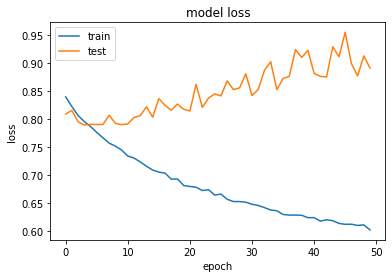

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

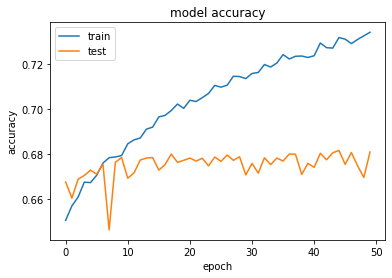

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy: {}".format(test_accuracy))

1/1 [==============================] - 0s 1ms/step - loss: 14.9596 - accuracy: 0.0000e+00
Test accuracy: 0.0


In [ ]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction, axis = 1)

In [ ]:
prediction, y_test

(array([4, 4, 4, 4, 4, 3, 4, 4, 4, 4]), array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8]))

# Neural network

In [ ]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

In [ ]:
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [ ]:
model = Sequential()

In [ ]:
model.add(Dense(units=32, activation='relu', input_shape=(X_train.shape[1], )))
#model.add(Dropout(0.4))
model.add(Dense(units=64, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(units=128, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(units=12, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 32)                7712      
_________________________________________________________________
dense_30 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_31 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_32 (Dense)             (None, 12)                1548      
Total params: 19,692
Trainable params: 19,692
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs = 50, shuffle = True, validation_data= (X_test, y_test), verbose=1)

Epoch 1/50
1390/1390 [==============================] - 2s 2ms/step - loss: 0.8905 - accuracy: 0.6366 - val_loss: 3.2393 - val_accuracy: 0.0396
Epoch 2/50
1390/1390 [==============================] - 2s 2ms/step - loss: 0.8306 - accuracy: 0.6475 - val_loss: 3.4733 - val_accuracy: 0.0685
Epoch 3/50
1390/1390 [==============================] - 2s 2ms/step - loss: 0.8124 - accuracy: 0.6529 - val_loss: 3.9006 - val_accuracy: 0.0715
Epoch 4/50
1390/1390 [==============================] - 2s 2ms/step - loss: 0.8028 - accuracy: 0.6570 - val_loss: 3.6394 - val_accuracy: 0.0989
Epoch 5/50
1390/1390 [==============================] - 2s 2ms/step - loss: 0.7953 - accuracy: 0.6602 - val_loss: 4.0074 - val_accuracy: 0.0578
Epoch 6/50
1390/1390 [==============================] - 2s 2ms/step - loss: 0.7876 - accuracy: 0.6623 - val_loss: 4.6992 - val_accuracy: 0.0837
Epoch 7/50
1390/1390 [==============================] - 2s 2ms/step - loss: 0.7776 - accuracy: 0.6666 - val_loss: 3.9561 - val_accuracy:

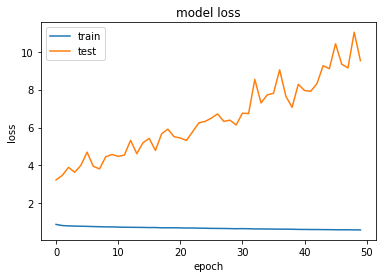

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

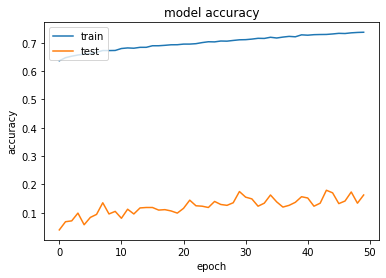

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Guassian SVM

In [ ]:
X_train.shape

(44472, 80, 3)

In [ ]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

In [ ]:
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
y_pred, y_test

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Grid search using RBF SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

In [ ]:
from sklearn.metrics import accuracy_score
final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test)
accuracy_score(y_test, y_pred)

# KNN

In [ ]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

In [ ]:
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
y_pred, y_test

(array([ 2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  3,  2,  2,
         2,  3,  4,  4,  3,  4,  3,  3,  3,  4,  4,  4,  4,  4,  4,  3,  3,
         3,  2,  3,  3,  3,  3, 11,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  4,  3,  3,  6,  4,  3,  3,  3,  3,  4,
         2,  4,  3,  2,  3,  4,  6,  3,  3,  3,  3,  3,  2,  3,  3,  3,  4,
         3,  6,  4,  4,  3,  3,  3,  3,  4,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  2,  3,  4,  2,  2,  2,  2,  2,  6,  4,  3,  3,  4,  3,
         3,  3,  6,  4,  4,  4,  3,  3,  3,  3,  3,  3,  3,  3,  4,  3,  3,
         3,  3,  4,  4,  3,  3,  4,  3,  3,  4,  3,  3,  4,  3,  3,  3,  6,
         4,  2,  4,  3,  3,  3,  2,  6,  3,  3,  3,  4,  3,  4,  3,  6,  2,
         3,  2,  6,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  3,  2,  2,
         3,  3,  3,  3,  3,  3,  4,  3,  4,  4,  4,  4,  4,  4,  4,  4,  3,
         3,  3,  4,  3,  3,  3,  3,  3,  4,  4,  3,  3,  4,  3,  3,  3,  3,
         3, 

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.1339421613394216